# 과제#3. [평가] 이동통신 고객 이탈 예측

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 00 통신회사의 올해 고객 목표는, **현재 고객수를 유지**하는 것입니다.
* 더욱 치열해진 경쟁 상황에서 고객수를 유지하는 것은 굉장히 도전적인 목표 입니다.
* 이를 위해 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 에이블러 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 예측 모델링을 의뢰하였습니다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### 2) 데이터 로딩

In [320]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
data = pd.read_csv(data_path)
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	OVER_15MINS_CALLS_PER_MONTH	|	 평균 장기통화(15분 이상) 횟수	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	REPORTED_USAGE_LEVEL	|	사용 수준 설문('very_little', 'little', 'avg', 'high', 'very_high') - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


----

## 1.데이터 탐색

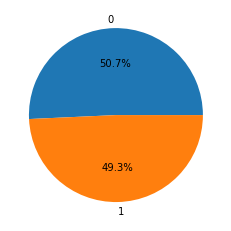

In [323]:
# 이탈율일 시각화 해보니 거의 50:50으로 나타났다.
# 타겟 데이터의 균형이 맞춰져 있는 것을 확인할 수 있었다.
college = mobile['CHURN'].value_counts()
x = college.index
y = college.values

plt.pie( y , labels = x , autopct = '%.1f%%')
plt.show()

<AxesSubplot:xlabel='HOUSE', ylabel='Count'>

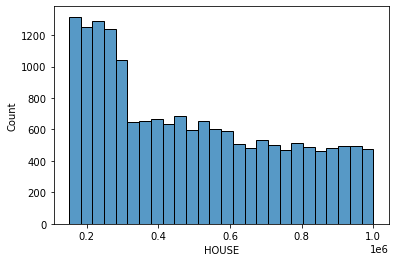

In [324]:
# 집값에 대해서 시각화를 해 보았다.
# '0.2_0.5', '0.5_0.8', '0.8_1.2', '1.2_1.6' 네 그룹으로 나누어서 비교해 볼수 있을것 같다.
sns.histplot(x='HOUSE', data=data)

<AxesSubplot:xlabel='HOUSE', ylabel='Count'>

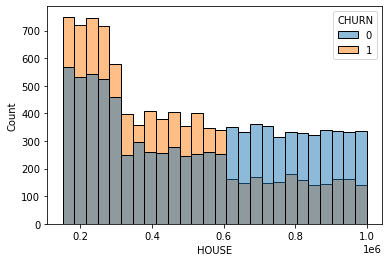

In [325]:
# 집값이 낮은 사람들의 경우 이탈율이 더 높은 것을 볼 수 있다.
# 대부분의 집값은 지역적으로 비슷하게 나타난다.
# 집값이 낮은 지역에서 해당 통신사의 통신 서비스 질이 나쁘지 않은지 확인해 볼 필요가 있다.
sns.histplot(x='HOUSE', hue='CHURN',data=data)

<AxesSubplot:xlabel='INCOME', ylabel='Count'>

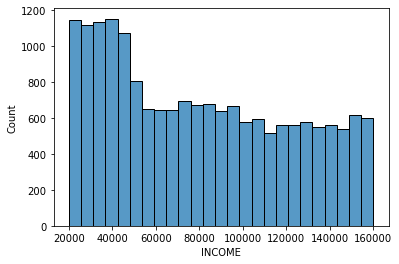

In [326]:
# 연 수입액에 대해서 그래프를 그려보았다.
# HOUSE 변수와 유사한 형태를 띄는 것을 확인할 수 있다.
# 연 수입 또한 '20000_50000', '50001_80000', '80001_120000', '120001_160000' 네 그룹으로 나누어 비교해 볼 수 있을 것 같다.
sns.histplot(x='INCOME', data=data)

<AxesSubplot:xlabel='INCOME', ylabel='Count'>

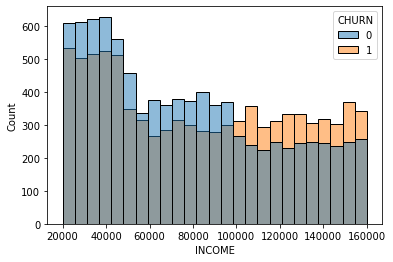

In [327]:
#고소득자의 경우 이탈율이 높은 것을 확인할 수 있다.
# 고소득자들이 느끼기에 자신들이 지불하는 금액에 비해 서비스의 질이 떨어진다고 느끼는 것 같다.
# 연 수입이 많은 사람들이 사용하는 요금제를 분석해 볼 필요가 있다.
sns.histplot(x='INCOME', hue='CHURN',data=data)

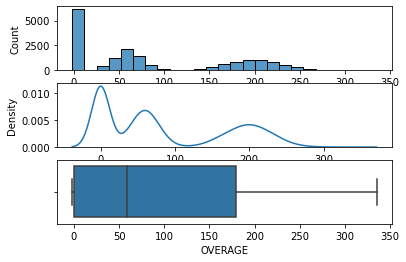

In [328]:
# 월 초과 사용 시간에 대해서 그래프를 그려보았다.
# 초과 사용이 없는 그룸(0), 초과 하는 그룹(1~100), 많이 초과하는 그룹(101~30)으로 나누어서 비교해보면 좋을 것 같다.
plt.subplot(3,1,1)
sns.histplot(x = 'OVERAGE', data=data)

plt.subplot(3,1,2)
sns.kdeplot(x = 'OVERAGE', data = data )

plt.subplot(3,1,3)
sns.boxplot(x = 'OVERAGE', data = data)

plt.show()

<AxesSubplot:xlabel='LEFTOVER', ylabel='Count'>

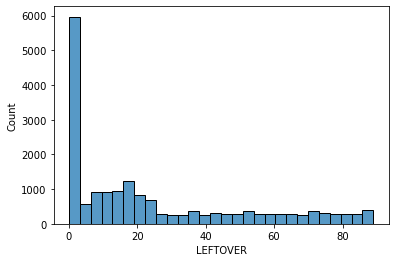

In [329]:
# LEFTOVER 변수를 시각화 하였다.
# 극겹하게 떨어지는 0과 1~24,25~60, 60~ 나머지 부분을 그룹화하여 비교하면 좋을것 같다. 
sns.histplot(x = 'LEFTOVER', data = data)

<AxesSubplot:xlabel='LEFTOVER', ylabel='Count'>

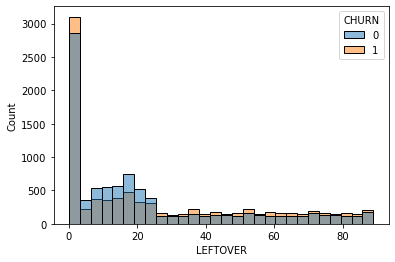

In [330]:
# 통화시간이 남지 않은 사람들과 과하게 많이 남은 사람들이 이탈 비율이 높은 것을 확인할 수 잇다.
# 
sns.histplot(x = 'LEFTOVER', hue='CHURN', data = data)

<AxesSubplot:xlabel='OVER_15MINS_CALLS_PER_MONTH', ylabel='Count'>

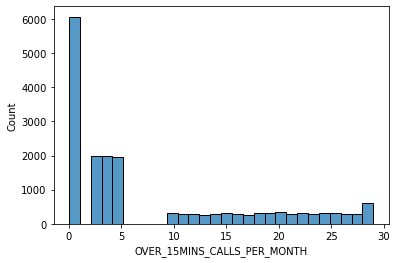

In [331]:
# 평균 15분 이상 통화를 하지 않는 사람들이 압도적으로 많다.
sns.histplot(x = 'OVER_15MINS_CALLS_PER_MONTH', data = data)

<AxesSubplot:xlabel='OVER_15MINS_CALLS_PER_MONTH', ylabel='Count'>

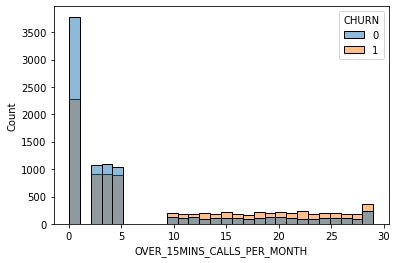

In [332]:
# 평균 15분 이상 통화를 하는 횟수가 많은 사람들의 이탈율이 높은 것을 볼 수 있다.
# 우리는 고객을 유지하는 것이 목적이기 때문에 현재 이탈이 1인 고객들을 0으로 바꾸는 것이 중요하다.
# 해당그래프를 보면 횟수가 10회 이상 되는 고객들의 그룹과 그렇지 않는 그룹의 이탈 비율이 확연하게 다르다.
# 그말은 10회 이상  고객들의 이탈율을 낮추면 자연스럽게 유지되는 고객 수가 늘것이다.
sns.histplot(x = 'OVER_15MINS_CALLS_PER_MONTH', hue='CHURN', data = data)

<AxesSubplot:xlabel='REPORTED_SATISFACTION', ylabel='count'>

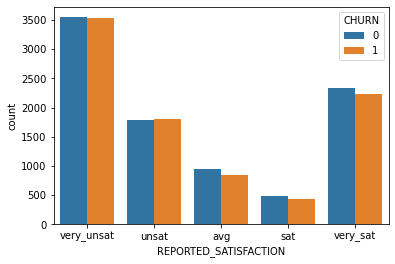

In [333]:
# 만족도 설문조사에 따른 이탈 여부를 시각화 해보았다.
# 만족도에 상관없이 이탈하는 고객은 50:50 인것을 확인 할 수 있다.
sns.countplot(data['REPORTED_SATISFACTION'], 
              order = ['very_unsat','unsat', 'avg', 'sat', 'very_sat'],
             hue = data['CHURN'])

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'actively_looking_into_it'),
  Text(1, 0, 'considering'),
  Text(2, 0, 'perhaps'),
  Text(3, 0, 'no'),
  Text(4, 0, 'never_thought')])

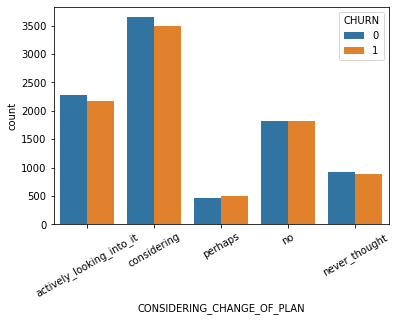

In [334]:
# 휴대폰 변경 여부 설문조사에 따른 이탈 여부를 시각화 해보았다.
# 변경 여부에 관계없이 이탈율은 50:50으로 나타나는 것을 확인할 수 있다.
sns.countplot(data['CONSIDERING_CHANGE_OF_PLAN'], 
              order = ['actively_looking_into_it', 'considering',  'perhaps', 'no','never_thought'],
             hue = data['CHURN'])
plt.xticks(rotation=30)

## 2.데이터 전처리 

In [335]:
target = 'CHURN'

### 2.1 데이터 정리

* feature와 , target으로 분할

In [336]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 불필요한 feature 제거
    * 제거해야 할 feature를 선정하고 제거하시오. 제거 이유를 주석으로 기술합니다.

In [337]:
x.drop(['id'], axis = 1, inplace = True)
x.head(10)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
0,1,47711,183,17,730589.0,192,19,5,unsat,little,considering
1,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no
2,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering
3,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought
4,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no
5,1,119591,0,43,231309.0,714,1,1,very_sat,little,considering
6,1,99548,235,0,238561.0,294,15,6,very_unsat,little,actively_looking_into_it
7,1,63338,50,57,394791.0,362,4,1,sat,little,no
8,1,133496,163,11,166179.0,864,10,5,NaN,little,actively_looking_into_it
9,1,155145,29,18,717451.0,671,4,4,unsat,high,considering


### 2.2 NaN에 대한 조치
* 데이터에 포함된 NaN에 대해서 조치 방법을 결정하고 적용합니다.
* **조치방법을 결정한 이유**를 주석으로 기술합니다.

In [338]:
# 결측치를 확인해보니 HOUSE 변수와 REPORTED_SATISFACTION 변수에 있었다.
x.isna().sum()

COLLEGE                          0
INCOME                           0
OVERAGE                          0
LEFTOVER                         0
HOUSE                          215
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION           38
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
dtype: int64

In [339]:
# 위에서 데이터 분석을 실시했을 떄 HOUSE와 INCOME의 그래프 모양이 유사한 것을 확인 했다.
# 연수입을 그룹별로 묶은 다음에 그룹의 평균을 결측치에 넣어주고자 한다.
# x 데이터에 IncomeGroup이라는 변수를 생성해 주었다.
x['IncomeGroup'] = pd.cut(data['INCOME'], bins=[20000,50000,80000,120000,160000]
                              ,labels=['20000_50000', '50001_80000', '80001_120000', '120001_160000'])

In [49]:
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,IncomeGroup
0,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,20000_50000
1,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,50001_80000
2,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,120001_160000
3,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,120001_160000
4,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,20000_50000


In [340]:
# HOUSE 변수에 IncomeGroup(연수입을 그룹화 한 변수)의 중앙값들을 넣어주어 결측치를 채웠다.
x['HOUSE'].fillna(x.groupby('IncomeGroup')['INCOME'].transform('median'), inplace = True)

In [341]:
x.isna().sum()

COLLEGE                         0
INCOME                          0
OVERAGE                         0
LEFTOVER                        0
HOUSE                           0
HANDSET_PRICE                   0
OVER_15MINS_CALLS_PER_MONTH     0
AVERAGE_CALL_DURATION           0
REPORTED_SATISFACTION          38
REPORTED_USAGE_LEVEL            0
CONSIDERING_CHANGE_OF_PLAN      0
IncomeGroup                     0
dtype: int64

### 2.3 (옵션) 추가변수 도출
* 기존 데이터셋의 변수를 이용하여 추가로 도출할 수 있는 변수가 있다면 수행합니다.
* 추가변수 생성시, 이유에 대해서 **주석**으로 기술합니다.

In [342]:
copy_data = data.copy()

In [343]:
# 만족도 설문의 결과를 1부터 5까지로 수치화 시킨다.
copy_data['REPORTED_SATISFACTION'].replace({'very_unsat':1,'unsat':2,'avg':3,'sat':4,'very_sat':5}, inplace=True)

In [344]:
# 변경계획 설문의 결과를 1부터 5까지로 수치화 시킨다.
copy_data['CONSIDERING_CHANGE_OF_PLAN'].replace({'never_thought':5, 'no':4, 'perhaps':3, 'considering':3,   'actively_looking_into_it':1}, inplace=True)

In [345]:
# SCORE 변수에 수치화한 두 설문의 값을 더 한다.
# 만족도가 최악이고 바꿀 계획이 있으면 2점, 만족도가 최상이고 바꿀 계획이 없으면 10점이다.
x['SCORE'] = copy_data['REPORTED_SATISFACTION'] + copy_data['CONSIDERING_CHANGE_OF_PLAN']

In [346]:
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,IncomeGroup,SCORE
0,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,20000_50000,5.0
1,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,50001_80000,6.0
2,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,120001_160000,5.0
3,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,120001_160000,6.0
4,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,20000_50000,6.0


<AxesSubplot:xlabel='SCORE', ylabel='Count'>

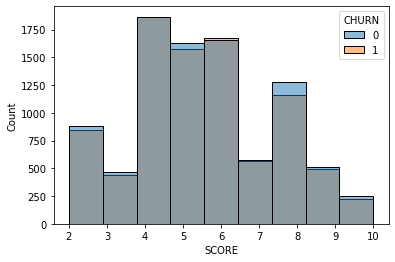

In [350]:
# 매우 불만족하고 휴대폰을 바꿀 계획이 있는 사람부터 매우 만족하고 바꿀 계획이 없는 사람들의 설문 지표를 합산하여 시각화 하였다.
# 만족 여부와 휴대폰 교체 여부와는 상관없이 이탈율이 50:50으로 나타났다.
# 다른 내용의 설문조사를 만들어서 어떤 서비스에 불만족을 갖고 있는 고객이 이탈하는지 알아볼 필요가 있다.
data['SCORE'] = copy_data['REPORTED_SATISFACTION'] + copy_data['CONSIDERING_CHANGE_OF_PLAN']
sns.histplot(x='SCORE', bins=9, hue=target, data=data)

### 2.4 가변수화
* 범주형 데이터이면서 값이 0,1 로 되어 있는 것이 아니라면, 가변수화를 수행해야 합니다.
* 대상이 되는 변수에 대해서 가변수화를 수행해주세요.

In [351]:
# 기존에 존재 하던 범주형 feature인 ['REPORTED_SATISFACTION','CONSIDERING_CHANGE_OF_PLAN', 'REPORTED_USAGE_LEVEL']를 가변수화 해줬다.
# 또한 새로 만든 IncomeGroup도 범주형 feature기 때문에 가변수화 해주었다.
dummy_vars = ['REPORTED_SATISFACTION','CONSIDERING_CHANGE_OF_PLAN', 'REPORTED_USAGE_LEVEL', 'IncomeGroup']
x = pd.get_dummies(x, columns=dummy_vars, drop_first=True)

In [352]:
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,SCORE,REPORTED_SATISFACTION_sat,...,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,IncomeGroup_50001_80000,IncomeGroup_80001_120000,IncomeGroup_120001_160000
0,1,47711,183,17,730589.0,192,19,5,5.0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,74132,191,43,535092.0,349,15,2,6.0,0,...,0,1,0,0,0,0,1,1,0,0
2,1,150419,0,14,204004.0,682,0,6,5.0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,159567,0,58,281969.0,634,1,1,6.0,0,...,1,0,0,0,0,1,0,0,0,1
4,1,23392,0,0,216707.0,233,0,15,6.0,0,...,0,1,0,0,0,0,1,0,0,0


In [353]:
# REPORTED_SATISFACTION의 결측치의 경우 그리 많지 않았기 떄문에
# KNNImputer를 사용해서 결측치를 처리했다.
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(x)

x = pd.DataFrame(imputed, columns=x.columns)
x.isna().sum()

COLLEGE                                     0
INCOME                                      0
OVERAGE                                     0
LEFTOVER                                    0
HOUSE                                       0
HANDSET_PRICE                               0
OVER_15MINS_CALLS_PER_MONTH                 0
AVERAGE_CALL_DURATION                       0
SCORE                                       0
REPORTED_SATISFACTION_sat                   0
REPORTED_SATISFACTION_unsat                 0
REPORTED_SATISFACTION_very_sat              0
REPORTED_SATISFACTION_very_unsat            0
CONSIDERING_CHANGE_OF_PLAN_considering      0
CONSIDERING_CHANGE_OF_PLAN_never_thought    0
CONSIDERING_CHANGE_OF_PLAN_no               0
CONSIDERING_CHANGE_OF_PLAN_perhaps          0
REPORTED_USAGE_LEVEL_high                   0
REPORTED_USAGE_LEVEL_little                 0
REPORTED_USAGE_LEVEL_very_high              0
REPORTED_USAGE_LEVEL_very_little            0
IncomeGroup_50001_80000           

In [354]:
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,SCORE,REPORTED_SATISFACTION_sat,...,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,IncomeGroup_50001_80000,IncomeGroup_80001_120000,IncomeGroup_120001_160000
0,1.0,47711.0,183.0,17.0,730589.0,192.0,19.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,74132.0,191.0,43.0,535092.0,349.0,15.0,2.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,150419.0,0.0,14.0,204004.0,682.0,0.0,6.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,159567.0,0.0,58.0,281969.0,634.0,1.0,1.0,6.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,23392.0,0.0,0.0,216707.0,233.0,0.0,15.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 2.5 데이터 분할

* test 3000건(test_size = 3000), random_state = 2022
* val 3000건(test_size = 3000), random_state = 2022
* train 나머지.

In [355]:
# x, y data를 train set과 test set으로 분할한다
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=3000, random_state = 2022)

In [356]:
# x_train, y_train data를 train set과 validation set으로 분할한다
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=3000, random_state = 2022)

In [357]:
x_train.isna().sum()

COLLEGE                                     0
INCOME                                      0
OVERAGE                                     0
LEFTOVER                                    0
HOUSE                                       0
HANDSET_PRICE                               0
OVER_15MINS_CALLS_PER_MONTH                 0
AVERAGE_CALL_DURATION                       0
SCORE                                       0
REPORTED_SATISFACTION_sat                   0
REPORTED_SATISFACTION_unsat                 0
REPORTED_SATISFACTION_very_sat              0
REPORTED_SATISFACTION_very_unsat            0
CONSIDERING_CHANGE_OF_PLAN_considering      0
CONSIDERING_CHANGE_OF_PLAN_never_thought    0
CONSIDERING_CHANGE_OF_PLAN_no               0
CONSIDERING_CHANGE_OF_PLAN_perhaps          0
REPORTED_USAGE_LEVEL_high                   0
REPORTED_USAGE_LEVEL_little                 0
REPORTED_USAGE_LEVEL_very_high              0
REPORTED_USAGE_LEVEL_very_little            0
IncomeGroup_50001_80000           

### 2.6 (옵션)스케일링 
* 스케일링을 필요로 하는 알고리즘이 있습니다. 
* 필요하다고 판단될때 수행합니다.

In [358]:
from sklearn.preprocessing import MinMaxScaler
col_x = list(x)
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)
x_test_s = scaler.transform(x_test)

## 3.모델링1 : 머신러닝

### 3.1 모델링을 위한 함수 불러오기

* **꼭 필요한 라이브러리 혹은 함수**만 불러옵니다. 무조건 다 불러오는 것은 지양해주세요.

In [359]:
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

### 3.2 모델링
* 최소 3개 이상의 알고리즘을 선정합니다.(알고리즘에는 최소 1개 이상의 앙상블 기법을 포함)
    * 아래 주어진 목록 이외의 알고리즘을 선정해도 좋습니다.
* 각 알고리즘별 튜닝을 수행하여 최적의 모델을 생성합니다.
    * 튜닝 방식은 GridSearchCV, RandomizedSearchCV 혹은 for loop 로 직접
    * 단, 선형회귀, 로지스틱 회귀의는 입력 변수(feature)를 조절하여 튜닝을 합니다.
    * 튜닝 과정에 대해서 주석으로 기술합니다.
* 모델링, 튜닝만 수행하는데 그치지 말고, 모델의 내용을 파악하기 위한 분석을 시도합니다. 코드 결과에 대한 분석 의견을 주석으로 기술합니다.
    * 예 : 모델 시각화 및 내용 파악, 튜닝 결과 분석 및 시각화

#### (1) Decision Tree

In [360]:
model = DecisionTreeClassifier()

params = { 'max_depth':range(1,10)}
model_dt = GridSearchCV(model, param_grid = params, cv = 10)
model_dt.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10)})

In [361]:
y_pred = model_dt.predict(x_val)

In [362]:
result={}
result['Decision Tree'] = precision_score(y_val, y_pred)

In [363]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 972  548]
 [ 304 1176]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.70      1520
           1       0.68      0.79      0.73      1480

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.71      3000
weighted avg       0.72      0.72      0.71      3000



#### (2) Random Forest

In [364]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [365]:
y_pred = model_rf.predict(x_val)

In [366]:
result['Random Forest'] = precision_score(y_val, y_pred)

In [367]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1055  465]
 [ 424 1056]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1520
           1       0.69      0.71      0.70      1480

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000



#### (3) XGBoost

In [368]:
model_xgb = XGBClassifier()

In [369]:
model_xgb.fit(x_train, y_train)

[12:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [370]:
y_pred = model_xgb.predict(x_val)

In [371]:
result['XGBoost'] = precision_score(y_val, y_pred) 

In [372]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1022  498]
 [ 406 1074]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1520
           1       0.68      0.73      0.70      1480

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000



#### (4) 추가

## 4.모델링2 : DL

### 4.1 모델링을 위한 함수 불러오기

In [373]:
import tensorflow as tf
from tensorflow import keras

### 4.2 모델링

* 딥러닝 모델을 3개 이상 생성하시오
    * 다양한 구조의 모델 3개 이상을 설계하시오. (히든레이어, 노드 수 조절)
    * 각 모델은 구조가 달라야 합니다.
    * 구조를 그렇게 구성한 이유를 주석으로 기술해 봅시다.
* 각 모델마다 
    * 구조를 summary 혹은 plot model로 확인
    * 학습 후 history plot 그리고 적절하게 학습이 되었는지 확인    

#### (1) 모델1

In [374]:
keras.backend.clear_session()

model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(8,input_shape=(x_train.shape[1],), activation = 'relu'))
model1.add(keras.layers.Dense(1, activation= 'sigmoid'))
model1.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = 'adam') 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [375]:
model1.fit(x_train, y_train, epochs = 100)
dl1_y_pred = model1.predict(x_val)

Epoch 1/100
375/375 [==============================] - 1s 1ms/step - loss: 2262.6311 - accuracy: 0.5502
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 75.8973 - accuracy: 0.5350
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 59.3135 - accuracy: 0.5487
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 70.9915 - accuracy: 0.5446
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 62.6400 - accuracy: 0.5494
Epoch 6/100
375/375 [==============================] - 0s 1ms/step - loss: 49.2015 - accuracy: 0.5623
Epoch 7/100
375/375 [==============================] - 1s 1ms/step - loss: 64.4824 - accuracy: 0.5471
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 65.6402 - accuracy: 0.5482
Epoch 9/100
375/375 [==============================] - 1s 1ms/step - loss: 45.6332 - accuracy: 0.5628
Epoch 10/100
375/375 [==============================] - 1s 1ms/step - loss: 64.9

In [376]:
dl1_y_pred = np.where(dl1_y_pred >= .5, 1, 0)
print(classification_report(y_val, dl1_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1520
           1       0.64      0.55      0.59      1480

    accuracy                           0.62      3000
   macro avg       0.63      0.62      0.62      3000
weighted avg       0.63      0.62      0.62      3000



In [377]:
dl_result ={}
dl_result['model1'] = classification_report(y_val, dl1_y_pred)

#### (2) 모델2

In [378]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(x_train.shape[1],))
hl = keras.layers.Dense(512, activation = 'relu')(il)
hl = keras.layers.Dense(256, activation = 'relu')(hl)
hl = keras.layers.Dense(128, activation = 'relu')(hl)
hl = keras.layers.Dense(64, activation = 'relu')(hl)
hl = keras.layers.Dense(32, activation = 'relu')(hl)
ol = keras.layers.Dense(1)(il)

model2 = keras.models.Model(il, ol)

model2.compile(loss='mae', optimizer='adam')

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [380]:
model2.fit(x_train, y_train, epochs = 100)
dl2_y_pred = model2.predict(x_val)

Epoch 1/100
375/375 [==============================] - 0s 1ms/step - loss: 56.3364
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 58.2155
Epoch 3/100
375/375 [==============================] - 0s 1ms/step - loss: 59.2365
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 54.7733
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 74.2029
Epoch 6/100
375/375 [==============================] - 0s 1ms/step - loss: 58.6292
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 63.7533
Epoch 8/100
375/375 [==============================] - 0s 1ms/step - loss: 59.3051
Epoch 9/100
375/375 [==============================] - 0s 1ms/step - loss: 73.6034
Epoch 10/100
375/375 [==============================] - 0s 1ms/step - loss: 55.9162
Epoch 11/100
375/375 [==============================] - 0s 1ms/step - loss: 63.8554
Epoch 12/100
375/375 [==============================] - 1s 1ms/step - loss: 55.8014
E

In [381]:
dl2_y_pred = np.where(dl2_y_pred >= .5, 1, 0)
print(classification_report(y_val, dl2_y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1520
           1       0.49      1.00      0.66      1480

    accuracy                           0.49      3000
   macro avg       0.25      0.50      0.33      3000
weighted avg       0.24      0.49      0.33      3000



In [382]:
dl_result['model2'] = classification_report(y_val, dl2_y_pred)

#### (3) 모델3

In [383]:
clear_session()

model3 = Sequential()
model3.add(Dense(50,input_shape=(x_train.shape[1],), activation = 'relu'))
model3.add(Dense(32,input_shape=(x_train.shape[1],), activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dense(1, activation= 'sigmoid'))
model3.compile(loss = 'binary_crossentropy', metrics=['accuracy'],optimizer = 'adam')  
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1250      
                                                                 
 dense_1 (Dense)             (None, 32)                1632      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
_________________________________________________________________


In [384]:
model3.fit(x_train, y_train, epochs = 100)
dl3_y_pred = model3.predict(x_val)

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 979.5118 - accuracy: 0.5147
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 228.8377 - accuracy: 0.5257
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 232.2731 - accuracy: 0.5347
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 191.8376 - accuracy: 0.5320
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 159.2131 - accuracy: 0.5453
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 149.6759 - accuracy: 0.5393
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 119.7095 - accuracy: 0.5483
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 108.4948 - accuracy: 0.5508
Epoch 9/100
375/375 [==============================] - 1s 2ms/step - loss: 88.0572 - accuracy: 0.5543
Epoch 10/100
375/375 [==============================] - 1s 2ms/step - loss

In [385]:
dl3_y_pred = np.where(dl3_y_pred >= .5, 1, 0)
print(classification_report(y_val, dl3_y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      1520
           1       0.00      0.00      0.00      1480

    accuracy                           0.51      3000
   macro avg       0.25      0.50      0.34      3000
weighted avg       0.26      0.51      0.34      3000



In [386]:
dl_result['model3'] = classification_report(y_val, dl1_y_pred)

#### (4) 추가

## 5.성능 비교
* 총 모델이 최소한 ML 3가지, DL 3가지 입니다. 이에 대해 성능을 평가합니다.
* 평가를 위한 적절한 지표(metric)을 결정하고 비교합니다.
    * **평가지표 선정 이유**를 주석으로 기술하시오.
* 최종 모델을 **선정하게 된 근거**를 주석으로 기술하시오.

### 5.1 평가지표 결정

* 어떤 지표로 성능을 비교할지 결정합니다.
* 결정 이유를 기술합니다.

지표로 precision과 Specificity을 선택할 것이다. 

현재 데이터를 분석하고 모델링 하는 목적은 '현재 고객수를 유지'하는 것이다.
즉 이탈이 0인 사람들을 1로 만들지 않는 것이 목적이다.
그렇다면 실제 이탈하지 않은 고객 주에서 이탈하지 않을 것이라 예측한 고객의 비율을 파악하고 그들이 만족하는 서비스를 제공해야한다.
또한 실제 이탈할 것이라 예측한 고객 중에서 실제 이탈한 고객의 비율을 찾아내어 이탈을 막아야 할것이다.

결론적으로 고객 유질르 위해서는 이탈하지 않는 고객들이 만족하는 서비스와 이탈할 것으로 예측되는 고객들이 불만족스러워 하는 서비스를 
모두 개선하는 것이 고객 유지를 위한 방법이라 생각된다.

### 5.2 성능 비교

* 성능을 비교하고, 최적의 모델을 선정하시오.
* 선정 근거를 주석으로 기술하시오.

In [387]:
result

{'Decision Tree': 0.6821345707656613,
 'Random Forest': 0.6942800788954635,
 'XGBoost': 0.683206106870229}

In [388]:
for i in dl_result:
    print(i)
    print(dl_result[i])

model1
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1520
           1       0.64      0.55      0.59      1480

    accuracy                           0.62      3000
   macro avg       0.63      0.62      0.62      3000
weighted avg       0.63      0.62      0.62      3000

model2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1520
           1       0.49      1.00      0.66      1480

    accuracy                           0.49      3000
   macro avg       0.25      0.50      0.33      3000
weighted avg       0.24      0.49      0.33      3000

model3
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1520
           1       0.64      0.55      0.59      1480

    accuracy                           0.62      3000
   macro avg       0.63      0.62      0.62      3000
weighted avg       0.63      0.62      0.62      3000

민감도를 따져 보았을 때 Random Forest 모델을 사용하기로 결정했다.

### 5.3 추가 분석 및 의견

* 성능을 한눈에 비교할 수 있는 방법을 고안해서 수행해 봅시다.

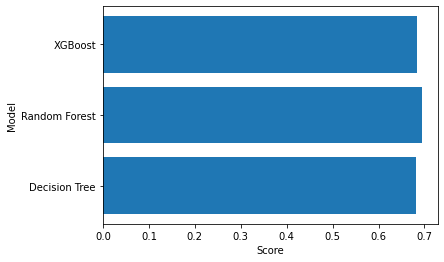

In [389]:
plt.barh(y=list(result), width=result.values())
plt.xlabel('Score')
plt.ylabel('Model')
plt.show()

* 여러분의 선정한 모델로 비즈니스 문제를 해결할 수 있을까요? 여러분의 의견을 적어 봅시다.

크게 해결할 수는 없을 것 같다. 

단변량 이변량 분석을 통해서 각 변수의 상관관계와 타겟을 해야하는 집단(집값이 낮은 집단, 연 수입이 높은 집단)
을 발견할 수는 있었지만, 정말 그들이 이탈할 것인지 지표를 확인할 수 있는 모델링의 성과가 그리 높지는 않았다.

단변량 분석을 통해 찾아낸 집단을 분석하기 위한 참고 자료로는 사용될 수 있겠지만 비지니스 문제 해결까지는 어려울 것 같다.

* 비즈니스 문제 해결을 위해서 더 해볼 수 있는 것은 무엇인가요?

정확하게 고객들이 이탈하는 이유를 알아내지 못했다.

통화 시간을 분석해보고 만족도 설문도 분석해보았지만 그것과는 큰 상관이 없는 것으로 나타났다.
그나마 장기통화를 자주 사용하는 고객들의 이탈율이 높은 것으로 나타났기 때문에 장기 통화를 자주 사용하는 고객들의 소리를 들어볼 필요가 있다.

비지니스 문제는 여러 문제가 복합적으로 이루어져 생긴다고 생각한다.
장기 통화를 자주 사용하는 고객들의 소리와 더불어 이탈이 생기는 다른 문제가 없는지 더 자세하게 알아 볼 필요가 있다.